In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import split_scale
from sklearn.feature_selection import SelectKBest, f_regression
import statsmodels.api as sm

import env
import wrangle

url = env.get_db_url('telco_churn')

In [163]:
df.head()

,monthly_charges,tenure,total_charges,contract_type,internet_type,dum_column,dum_column2
0,59.9,9,542.40,0,1,1,2
1,73.9,4,280.85,0,2,1,2
2,98.0,13,1237.85,0,2,1,2
3,83.9,3,267.40,0,2,1,2
4,69.4,9,571.45,0,1,1,2


In [3]:
#telco db
#df = wrangle.wrangle_churn()
df.drop(columns=['customer_id'],inplace=True)

In [16]:
df['contract_type'] = np.where(df['contract_type']== 'One year',1,df['contract_type'])

In [94]:
df['dum_column'] = 1

,monthly_charges,tenure,total_charges,contract_type,internet_type,dum_column,dum_column2
0,59.9,9,542.40,0,1,1,2
1,73.9,4,280.85,0,2,1,2
2,98.0,13,1237.85,0,2,1,2
3,83.9,3,267.40,0,2,1,2
4,69.4,9,571.45,0,1,1,2


In [75]:
#split train and test data
train, test = split_scale.split_my_data(df)

#scale with MinMax
#scaler, train,test = split_scale.standard_scaler(train,test)

In [165]:
#X and y train and test
train, test = split_scale.split_my_data(df)
X_train = train.drop(columns='total_charges')
y_train = train[['total_charges']]
X_test = test.drop(columns='total_charges')
y_test = test[['total_charges']]


type(train)

pandas.core.frame.DataFrame

In [77]:
#1 f regression testing features *unscaled*

f_selector = SelectKBest(f_regression,k=2)

f_selector.fit(X_train,y_train)

f_support = f_selector.get_support()
f_feature = X_train.loc[:,f_support].columns.tolist()

print(str(len(f_feature)), 'selected features')
print(f_feature)

2 selected features
['monthly_charges', 'tenure']


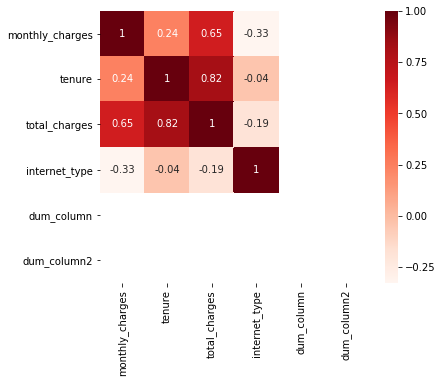

In [78]:
#1 plot correlations of x features to y *unscaled*
plt.figure(figsize=(6,5))
cor = train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [79]:
#2 scaled f reg
scaler, train,test = split_scale.standard_scaler(train,test)
#X and y train and test
X_train = train.drop(columns='total_charges')
y_train = train[['total_charges']]
X_test = test.drop(columns='total_charges')
y_test = test[['total_charges']]


In [80]:
train.head(2)

,monthly_charges,tenure,total_charges,contract_type,internet_type,dum_column,dum_column2
5472,1.132490,1.609417,2.269084,1.568594,0.170030,0.0,0.0
5425,-1.500284,1.609417,-0.372265,1.568594,1.532453,0.0,0.0


In [81]:
f_selector = SelectKBest(f_regression,k=2)
f_selector.fit(X_train,y_train)

f_support = f_selector.get_support()
f_feature = X_train.loc[:,f_support].columns.tolist()

print(str(len(f_feature)), 'selected features')
print(f_feature)

2 selected features
['monthly_charges', 'tenure']


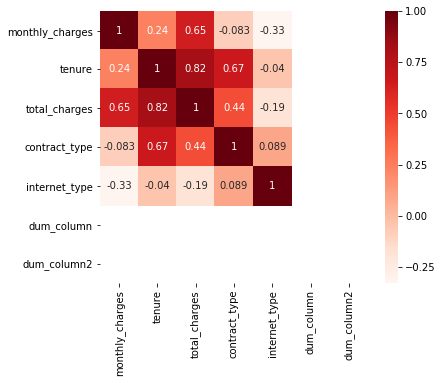

In [82]:
plt.figure(figsize=(6,5))
cor = train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [83]:
import statsmodels.api as sm

#ols model
ols_model = sm.OLS(y_train,X_train)

#fit model
fit = ols_model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          total_charges   R-squared (uncentered):                   0.895
Model:                            OLS   Adj. R-squared (uncentered):              0.895
Method:                 Least Squares   F-statistic:                          1.199e+04
Date:                Wed, 16 Oct 2019   Prob (F-statistic):                        0.00
Time:                        09:48:07   Log-Likelihood:                         -1640.8
No. Observations:                5625   AIC:                                      3290.
Df Residuals:                    5621   BIC:                                      3316.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
monthly_charges     0.4797      0.005     96.888      0.000       0.470       0.489
tenure              0.7031      0.006    110.335      0.000       0.691       0.716
contract_type       0.0110      0.006      1.768      0.077      -0.001       0.023
internet_type      -0.0010      0.005     -0.223      0.824      -0.010       0.008
dum_column               0          0        nan        nan           0           0
dum_column2              0          0        nan        nan           0           0
==============================================================================
Omnibus:                       35.946   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.911
Skew:                           0.112   Prob(JB):                     3.20e-07
Kurtosis:                       2.722   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [84]:
# OLS backward elimination based on pvalue

cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p = []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if (pmax>.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['monthly_charges', 'tenure', 'dum_column', 'dum_column2']


In [97]:
from sklearn.linear_model import LassoCV
    
reg = LassoCV()
reg.fit(X_train,y_train)

print("Best alpha using built in LassoCV: %f" % reg.alpha_)
print("Best score using built in LassoCV: %f" % reg.score(X_train,y_train))
coef = pd.Series(reg.coef_,index=X_train.columns).sort_values(ascending=False)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built in LassoCV: 0.000825
Best score using built in LassoCV: 0.895070
Lasso picked 4 variables and eliminated the other 2 variables


tenure             0.703041
monthly_charges    0.479058
contract_type      0.010099
dum_column2        0.000000
dum_column         0.000000
internet_type     -0.000329
dtype: float64

Text(0.5, 1.0, 'Feature importance using Lasso Model')

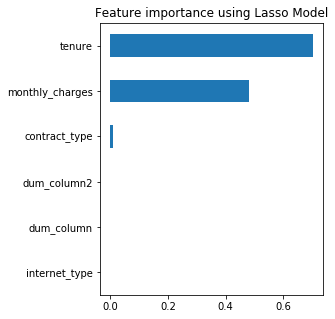

In [87]:
imp_coef = coef

import matplotlib

matplotlib.rcParams['figure.figsize'] = (4.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()

#Initializing RFE model, with parameter to select top 2 features. 
rfe = RFE(model, 2)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)

print(rfe.support_)
print(rfe.ranking_)

[ True  True False False False False]
[1 1 2 3 5 4]


In [138]:
number_of_features_list = np.arange(1,5)
high_score = 0

number_of_features=0
score_list = []

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]
        
print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features,high_score))

Optimum number of features: 4
Score with 4 features: 0.894981


In [152]:
list(range(1,X_train.shape[1]+1))

[1, 2, 3, 4, 5, 6]

In [155]:
#5 function returning number of features from RFE function.
def optimum_features(data):
    number_of_features_list = list(range(1,X_train.shape[1]+1))
    high_score = 0

    number_of_features=0
    score_list = []

    for n in range(len(number_of_features_list)):
        model = LinearRegression()
        rfe = RFE(model,number_of_features_list[n])
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        model.fit(X_train_rfe,y_train)
        score = model.score(X_test_rfe,y_test)
        score_list.append(score)
        if(score>high_score):
            high_score = score
            number_of_features = number_of_features_list[n]
    return number_of_features

In [156]:
optimum_features(X_train)

4

In [115]:
def top_n_features(num_features):
    features = num_features
    reg = LassoCV()
    reg.fit(X_train,y_train)
    coef = pd.Series(reg.coef_,index=X_train.columns).sort_values(ascending=False)
    return coef.head(num_features)

In [159]:
top_n_features(optimum_features(X_train))

tenure             0.703041
monthly_charges    0.479058
contract_type      0.010099
dum_column2        0.000000
dtype: float64

In [161]:
X_train

,monthly_charges,tenure,total_charges,contract_type,internet_type,dum_column,dum_column2
5472,1.132490,1.609417,2.269084,1.568594,0.170030,0.0,0.0
5425,-1.500284,1.609417,-0.372265,1.568594,1.532453,0.0,0.0
3563,1.299016,0.464646,0.972414,-0.831009,0.170030,0.0,0.0
2096,0.148322,-1.252510,-0.961215,-0.831009,0.170030,0.0,0.0
7008,-0.399548,-0.475701,-0.495288,1.568594,-1.192393,0.0,0.0


40500